# Python for Linguists module 1.4

Welcome to module 1.4. In this module, we will start calculating statistics using real corpus. 

Let's first refresh your memory on ngrams and probabilities by completing the following quiz:

## Pre-module quiz

Given the sequence 'aabbdab', what is *P*(b|a)?

A. 1/2

B. 1/3

C. 2/3

D. 0

The correct answer is C. 

## Importing packages

In [1]:
#For tokenization of a sentence
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English() 
tokenizer = nlp.Defaults.create_tokenizer(nlp)

## Processing the corpora

We will be using the Shakespeare corpus. The relative path to the corpus file is ../../corpora/shakespeare (.. indicates the parent directory). 
Let's first load the corpus by using the open function:

In [2]:
f=open('../../corpora/Shakespeare','r')

We declared the variable f to open the Shakespeare file. Open takes 2 arguments, the path to the file that we want to open and a string that represents the kinds of permission or operation we want to do on the file. Here 'r' refers to the permission of 'read-only'. 

Let's first import spac for tokenization:

In [3]:
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English() 
tokenizer = nlp.Defaults.create_tokenizer(nlp)

Let's write a for loop to process each line of the file and store the processed lines as tokenized word lists into another variable

In [4]:
f_processed=[] # a list to store the processed lines
for line in f:
    #for each line, we do:
    #1. remove control characters like \t \r \n
    line=line.strip()
    #2. skip the empty lines
    if line=='':
        continue
    else: 
        #3. tokenize the sentence into word list:
        tokens =[str(tok) for tok in tokenizer(line)]# tokens are now a list of words for the current line
        f_processed.append(tokens)

## Counting Vocabulary

Now let's loop over the word lists in f_processed to create a vocabulary dictionary:

In [5]:
vocab={}# create a vocabulary dictionary where key is the word and value is the count
for line in f_processed:
    for word in line:
        if word in vocab:
            vocab[word]+=1 # update the count for an existing word
        else:
            vocab[word]=1 # initilize the count for a new word


### Practice quiz 1:
What is the count of the word 'book' in the corpus?


In [6]:
vocab['book']

101

## Caluating Type-token ratio

Let's calculate type count first:

In [7]:
type_count=len(vocab.keys())# the number of types is just the length of the key list
print (type_count)

32864


Let's caculate token count:

In [8]:
# Let's create a loop to aggregate the token counts in the vocabulary:
token_count=0
for word in vocab:
    token_count+=vocab[word]
print (token_count)


1133363


In [9]:
#Let's calculate the type-token ratio:
ttr=type_count/token_count
print (ttr)

0.028996888022637054


Alternatively, we could wrap the calculation up into a function that takes in vocab dictionary and outputs the ttr

In [10]:
def ttr_cal(vocab):
    type_count=len(vocab.keys())
    token_count=0
    for word in vocab:
        token_count+=vocab[word]
    ttr=type_count/token_count
    return ttr

In [11]:
print (ttr_cal(vocab))

0.028996888022637054


## Plotting a frequency distribution

Let's first import matplotlib for plotting

In [12]:
import matplotlib.pyplot as plt

Then we can sort the words to get the top-100 frequent words

In [13]:
topn=100
vocab_sorted=sorted(vocab.items(),key=lambda x: x[1],reverse=True)[:topn]


loop through the sorted vocabulary to get words and counts for plotting the graphs


In [14]:
words=[]
counts=[]
for w_c in vocab_sorted:
    w=w_c[0]
    words.append(w)
    count=w_c[1]
    counts.append(count)


We could now plot a histogram using the words and counts

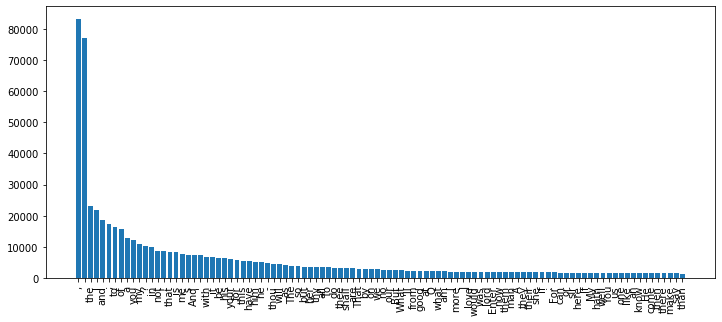

In [15]:
plt.figure(figsize=(12,5)) #figure size
plt.bar(words,counts) #plot the historgram
plt.xticks(rotation=90) # rotate the x label
plt.show()

### Practice quiz 2:
Try changing topn and observe what are the properties of the top-frequent words?


## Counting bigrams

A bigram is a sequence of adjacent two words. Let's create a nested dictionary to store the bigrams. They key will be each bigram and the value will be counts


Let's first loop through the lines in f_processed

In [16]:
bigram_dict={}
for line in f_processed:
    #insert start <start> and end <end> token
    line=['<start>']+line+['<end>']
    for i,w in enumerate(line):
        w_first=w
        if i+1<len(line): #not the end of the line
            w_second=line[i+1]
            bigram=(w_first,w_second) #a tuple to represent bigram
            if bigram not in bigram_dict:
                bigram_dict[bigram]=1
            else:
                bigram_dict[bigram]+=1
                
        

### Practice quiz 3:
What is the count of the bigram 'thank you'?

In [17]:
bigram_dict[('thank','you')]

124

## Language modelling

Language modelling is a fundamental task in computational lingustics where the aim is to predict the probablity of a sequence of tokens occuring. We will consider tokens to be words in this exercise, but they can be many other things depending on the application (perhaps characters, utterances, phonemes, _etc_). 

Formally, we want to estimate the probablity $P(w_{1},\ldots ,w_{m})$ of an $m$-length sequence, using some given corpus.

There are many techniques for language modelling; we will consider here a very simple approach called $n$-gram models. These models make the assumption that the probability of a word only depends on the previous $n-1$ context words in the sequence. If $n=1$, we call this a *unigram* model, if $n=2$, it's a *bigram* model etc.

So for example, given a sequence of words: *'to be or not to'* what is the probablity the next word will be *'be'*?  In $n$-gram models, this is calculated using *conditional probablity*: $P(`be'\mid \text{`to be or not to'})$ where we estimate the probablity of the entire sequence using the probablity chain rule (_i.e_. multiplying the conditional probabilities of the sequence):


$$P(w_{1},\ldots ,w_{m})=\prod _{{i=1}}^{m}P(w_{i}\mid w_{1},\ldots ,w_{{i-1}})\approx \prod _{{i=1}}^{m}P(w_{i}\mid w_{{i-(n-1)}},\ldots ,w_{{i-1}})$$

We can estimate the conditional probility from our training corpus by simply counting:

$$P(w_{i}\mid w_{{i-(n-1)}},\ldots ,w_{{i-1}})={\frac  {{\mathrm  {count}}(w_{{i-(n-1)}},\ldots ,w_{{i-1}},w_{i})}{{\mathrm  {count}}(w_{{i-(n-1)}},\ldots ,w_{{i-1}})}}$$

### Unigram language model
Let's start by building the most basic $n$-gram model, a unigram model where the conditional probablity for each word is simply the probablity of the word occuring in the corpus data: it does not dependent on any of the previous words in the sequence.

We can start by defining a function called *unigram_prob* which calculates the probability of a unigram given as an input parameter

In [18]:
def unigram_prob(word):
    return float(vocab[word]/token_count)

Let's test this by calculating the probability of the word "horse" occuring in the corpus:

In [19]:
unigram_prob("horse")

0.00021175916277485677

### Practice quiz 4:
Calculate the probability and the effect of capitalisation on the definite article. Try "The" vs "THE" vs "the", and note how much the probability differs

In [20]:
unigram_prob("The")

0.0035452013167890607

In [21]:
unigram_prob("THE")

0.00010323259185274268

In [22]:
unigram_prob("the")

0.020503580935675506

To calculate the probability of a sequence (a sentence, paragraph, _etc_.) occurring, we use the chain rule of probability by multiplying the unigram probability of individual words. So lets calculate the probability of the sequence: *'To be, or not to be, that is the question:'*

In [23]:
unigram_prob("To") * unigram_prob("be") * unigram_prob("or")* unigram_prob("not") * unigram_prob("to") * unigram_prob("be") * unigram_prob(",") * unigram_prob("that") * unigram_prob("is") * unigram_prob("the") * unigram_prob("the") * unigram_prob("question") * unigram_prob(":")

5.408562399710954e-30

The probablity value of our example sequence is a very small number! In fact, it is so small that it's about the same probability of picking the same ant thrice at random from all the ants on the planet!

What happens if we continue to add further words to this sequence?  

### Log-probability

Eventually the probability values will get so tiny that computers will not be able to represent them correctly in memory; this is known as an *underflow error*.  It will not require much more text to get an underflow error: a simple paragraph using our unigram model will result in one! 

Fortunately, there is a very simple way to avoid this: we can use log-probability instead of regular probability. To do so, we simply use the log function in our unigram_prob function as follows:

In [24]:
import math

def unigram_prob(word):
    return math.log(float(vocab[word]/token_count))

Now let's try calculacting the log-probability for the word "horse":

In [25]:
unigram_prob("horse")

-8.460060953704279

To calculate the log-probability of an entire sequence, we simply add the individual log-probablity values of individual unigrams instead of multiplying them. 

Let's write a function that calculates the log-probability of a given text sequence (as a single string). The function must tokenize the input string correctly before performing the calculation.

In [26]:
def unigram_prob_for_sequence(tokens):
    return sum([unigram_prob(tok) for tok in tokens])

Let's now calculate the log-probablity of our example sequence:

In [27]:
text = "To be, or not to be, that is the question:"
example_sequence = [str(tok) for tok in tokenizer(text)]
unigram_prob_for_sequence(example_sequence)

-66.11605999786988

### Practice quiz 5:
Calculate the log-probability of the sentence: *'A horse, a horse! My kingdom for a horse!'*

In [28]:
text = "A horse, a horse! My kingdom for a horse!"
tokens = [str(tok) for tok in tokenizer(text)]
unigram_prob_for_sequence(tokens)

-74.21539318177221

### Bigram language model

Unlike the unigram language model above, a bigram language model uses the context history. It uses conditional probability to estimate the probability of a word occuring relative to the occurance of its predecessor in the sequence:

$$P(w_{i}\mid w_{i-1})={\frac  {{\mathrm  {count}}(w_{i-1},w_{i})}{{\mathrm  {count}}(w_{i-1})}}$$

Let's implement a bigram_prob function that calculates the bigram conditional probability for a single token:


In [29]:
def bigram_prob(w1, w2):
    return math.log(float(bigram_dict[(w1,w2)]/vocab[w1]))

Let's test this by calculating the conditional log-probability for the bigram "to be", i.e., the log-probability of the word "be" given the word "to" appearing before it:

In [30]:
bigram_prob("to", "be")

-3.0051406123266844

As before, we can write a function to calculate the log-probability for a sequence of text using our bigram language model.

In [31]:
def bigram_prob_for_sequence(tokens):
    return sum([bigram_prob(w1,w2) for w1,w2 in zip(tokens, tokens[1:])])

Let's use this function to calculate the log probability of our example sequence, and compare it to the unigram language model.

In [32]:
unigram_prob_for_sequence(example_sequence) # log-probability using unigram

-66.11605999786988

In [33]:
bigram_prob_for_sequence(example_sequence) # log-probability using bigram

-49.81572109265195

It is interesting to note that the log-probability value using the bigram model is substantially larger (the sequence is much likelier to occur). Is this perhaps because the bigram language model takes the context history into account whereas a unigram language model does not?

We discuss how to correctly evaluate language models in the next section.

### Practice quiz 6:
Calculate and compare the unigram and bigram log-probabilities of the sentence: *'Double, double, toil and trouble; fire burns, and cauldron bubble.'*

In [34]:
text = "Double, double, toil and trouble; fire burns, and cauldron bubble."
tokens = [str(tok) for tok in tokenizer(text)]
unigram_prob_for_sequence(tokens) # log-probability using unigram

-107.52272746936798

In [35]:
bigram_prob_for_sequence(tokens) # log-probability using bigram

-65.18214590870909

## Evaluating language models

Language models are evaluated using *perplexity* ($P$), a measure of how well a probability model predicts a given sample (e.g. text sequences).

Perplexity is defined as $P = 2^{{h(s)}}$ where $h$ is the information entropy per word for a given input $s$. $h(s)$ can be calculated as follows:

$$h(s)=\frac{-1}{|s|}\sum _{w \in s}\log _{2}P(w)$$

Here, $s$ is some sample text and $|s|$ is the number of tokens in $s$.

The value of perplexity can be thought of as the number of choices the model needs to make on average per token of the input sequence. The lower the perplexity score, the better the language model is since the model has fewer choices on average for the input sequence. 

Let's implement a simple function to calculate the perplexity, taking as input the log-probability (calculated by a language model) and the length of a sequence (in number of tokens).

In [36]:
def perplexity(log_prob, length):
    H =  - (log_prob/ math.log(2)) / length  #change of log-base from base 10 to base 2, then normalize by length
    return math.pow(2,H)

Let's calculate the perplexity of both language models by simply calling the respective functions, and feed the results to the perplexity function above along with the length of the example sequence:

In [37]:
perplexity(bigram_prob_for_sequence(example_sequence),len(example_sequence))

46.1537652847171

In [38]:
perplexity(unigram_prob_for_sequence(example_sequence),len(example_sequence))

161.7174649447508

### Practice quiz 7:
Which of the two models has a lower perplexity?  measure the perplixity of both models using the example text sentences from previous quizes. 

Can you find a text string where the unigram model has a lower perplexity than the bigram model?